In [1]:
import sys
import os
# Get the parent directory path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

Load the images names

# Load Ground Truth

In [2]:
import json
import numpy as np
def chesspos2number(chesspos):
    col = ord(chesspos[0])-ord('a')
    col = 7-col
    row = int(chesspos[1])-1
    return row, col
def load_groundTruth():
    anns = json.load(open("../annotations.json"))
    categories = [c['name'] for c in anns['categories']]
    ids = []
    file_names = []
    imagesDic = {}
    for x in anns['images']:
        path = "../"+x['path']
        file_names.append(path)
        ids.append(x['id'])
        imagesDic[x['id']] = path
    file_names = np.asarray(file_names)
    #restrict ther the number of filenames to 10
    ids = np.asarray(ids)
    boards=[[[12 for _ in range(8)] for _ in range(8)] for _ in range(len(file_names))]
    for piece in anns['annotations']['pieces']:
        idx = np.where(ids == piece['image_id'])[0][0]
        row, col = chesspos2number(piece['chessboard_position'])
        piceId =int(piece['category_id'])
        boards[idx][row][col] = piceId#["chessred2k"]
    split_ids = np.asarray(anns['splits']['test']['image_ids']).astype(int)

    intersect = np.isin(ids, split_ids)
    split_ids = np.where(intersect)[0]
    file_names = file_names[split_ids]
    file_names = file_names#[:45]
    #boards = boards[split_ids]
    ids = ids[split_ids]
    splitImages = []
    splitGroundTruth = []
    for id in ids:
        splitImages.append(imagesDic[id])
        splitGroundTruth.append(boards[id])
    #print(f"Number of {partition} images: {len(file_names)}")
    return splitImages ,splitGroundTruth
    #return splitImages[:50] ,splitGroundTruth[:50]
    #return splitImages[:5] ,splitGroundTruth[:5]
    #return splitImages[1:2] ,splitGroundTruth[1:2]
images,GroundTruth = load_groundTruth()
print(images[:2])
print(GroundTruth[:2])
print(len(GroundTruth),len(images))

['../images/0/G000_IMG000.jpg', '../images/0/G000_IMG001.jpg']
[[[1, 2, 3, 5, 4, 3, 2, 1], [0, 0, 0, 0, 0, 0, 0, 0], [12, 12, 12, 12, 12, 12, 12, 12], [12, 12, 12, 12, 12, 12, 12, 12], [12, 12, 12, 12, 12, 12, 12, 12], [12, 12, 12, 12, 12, 12, 12, 12], [6, 6, 6, 6, 6, 6, 6, 6], [7, 8, 9, 11, 10, 9, 8, 7]], [[1, 2, 3, 5, 4, 3, 2, 1], [0, 0, 0, 0, 0, 0, 12, 0], [12, 12, 12, 12, 12, 12, 12, 12], [12, 12, 12, 12, 12, 12, 0, 12], [12, 12, 12, 12, 12, 12, 12, 12], [12, 12, 12, 12, 12, 12, 12, 12], [6, 6, 6, 6, 6, 6, 6, 6], [7, 8, 9, 11, 10, 9, 8, 7]]]
2129 2129


In [3]:
import cv2
import numpy as np
import copy

def findHorse(img_original, x_offset=0, y_offset=0, width_box=30, height_box=30,debug=False):
    """
    Draws boxes at the four corners of an image.
    
    Parameters:
    - img: Input image (BGR format)
    - x_offset, y_offset: Offset for corner positions
    - width_box, height_box: Size of the corner boxes
    """
    img = img_original.copy()
    # Convert to grayscale (though we'll draw on the original color image)
    black_and_white = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    height, width = black_and_white.shape[:2]
    
    # Define the four corners with optional offsets
    corners = [
        (x_offset, height - 1 - height_box - y_offset),            # Bottom-left
        (y_offset, x_offset),                          # Top-left
        (width - 1 - height_box - y_offset, height - 1 - width_box - x_offset), # Bottom-right
        (width - 1 - width_box - x_offset , y_offset)             # Top-right
    ]
    convert = ["top_left",  "bottom_left","top_right", "bottom_right"]
    # Create a list to hold all box contours
    all_contours = []
    intensities = []
    count = 1
    for (x, y) in corners:
        if count%2 ==0:
            temp = width_box
            width_box = height_box
            height_box = temp
        count += 1
        # Define a rectangle (box) around the corner point
        box = np.array([
            [x, y],                          # Top-left of the box
            [x + width_box, y],               # Top-right of the box
            [x + width_box, y + height_box],  # Bottom-right of the box
            [x, y + height_box]               # Bottom-left of the box
        ], dtype=np.int32)
        
        all_contours.append(box)
        mask = np.zeros_like(black_and_white, dtype=np.uint8)
        cv2.drawContours(mask, [box], -1, 255, -1)  # Fill the contour (thickness=-1)
        mean_intensity = cv2.mean(black_and_white, mask=mask)[0]
        intensities.append(mean_intensity)
    index = np.argmin(intensities)

    # Draw all the box contours on the original image
    cv2.drawContours(
        img,
        [all_contours[index]],
        #all_contours,
        contourIdx=-1,          # Draw all contours
        color=(0, 255, 0),      # Green color (BGR)
        thickness=2             # Line thickness
    )
    oriented_board = copy.deepcopy(img)
    # Display results
    rotation_code = 0
    if index == 2:
        rotation_code = 270 
        oriented_board = cv2.rotate(oriented_board, cv2.ROTATE_90_COUNTERCLOCKWISE)

    elif index == 0:
        rotation_code = 180  
        oriented_board = cv2.rotate(oriented_board, cv2.ROTATE_180)
    elif index == 1:
        rotation_code = 90  
        oriented_board = cv2.rotate(oriented_board, cv2.ROTATE_90_CLOCKWISE)

    if(debug):
        cv2.imshow("Image with Corner Boxes", img)
        cv2.imshow("Oriented Board", oriented_board)
        cv2.waitKey(0)
        #cv2.imshow("Grayscale Version", black_and_white)
        #cv2.waitKey(0)
        cv2.destroyAllWindows()
    
    return oriented_board,rotation_code
def rotateBoard(img,rotation):
    oriented_board = img
    if rotation == 270:
        oriented_board = cv2.rotate(oriented_board, cv2.ROTATE_90_COUNTERCLOCKWISE)
    elif rotation == 180:
        oriented_board = cv2.rotate(oriented_board, cv2.ROTATE_180)
    elif rotation == 90:
        oriented_board = cv2.rotate(oriented_board, cv2.ROTATE_90_CLOCKWISE)
    return oriented_board

# Example usage:
# image = cv2.imread("your_image.jpg")
# processed_image = findCorners(image, width_box=40, height_box=40)

# Yolov11M

In [4]:
from ultralytics import YOLO
yoloResolution = 1856
def runYoloOnImages(images):
    results = []
    model = YOLO("best2.0.pt")
    batch_size = 5
    # Calculate number of batches needed (rounding up)
    num_batches = (len(images) + batch_size - 1) // batch_size

    # Split into batches
    batches = [images[i*batch_size : (i+1)*batch_size] 
            for i in range(num_batches)]

    # Then process each batch
    for batch in batches:
        result = model.predict(batch, save=False, imgsz=yoloResolution, conf=0.6,batch=1,verbose=False)
        for i in range(len(result)):
            results.append(result[i].boxes)
    return results
yoloResults = runYoloOnImages(images)
print(len(yoloResults))

2129


# Convert yolo bounding boxes to contours

In [5]:
def rect_to_contour(x1, y1, x2, y2):
    # Convert coordinates to integers
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
    # Contour must be a numpy array of shape (N, 1, 2)
    contour = np.array([
        [[x1, y1]],  # Top-left
        [[x2, y1]],  # Top-right
        [[x2, y2]],  # Bottom-right
        [[x1, y2]]   # Bottom-left
    ], dtype=np.int32)
    return contour
YoloContours = []
YoloBBids =  []
for i,img in enumerate(images):
    yoloResult = yoloResults[i]
    if len(yoloResult) == 0:
        print("No boxes detected in image: ", img)
        continue
    img_original = cv2.imread(img)
    #img_original = cv2.resize(img_original, (yoloResolution, yoloResolution))
    img_height, img_width = img_original.shape[:2]
    print("Processing image: ", img, " with shape: ", img_original.shape)
    contours = []
    BBids = []
    for box in yoloResult:
        xyxy = box.xyxy[0].cpu().numpy()
        #print("Box coordinates: ", xyxy)
        contour = rect_to_contour(xyxy[0], xyxy[1], xyxy[2], xyxy[3])
        #print("Contour: ", contour)
        contours.append(contour)
        #print(int(box.cls.cpu()))
        BBids.append(int(box.cls.cpu()))
    YoloContours.append(contours)
    YoloBBids.append(BBids)
    #cv2.drawContours(img_original, contours, -1, (0, 255, 0), 4)
    #img_original = cv2.resize(img_original, (720, 720), img_original)
    #cv2.imshow("YOLO Boxes", img_original)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()




Processing image:  ../images/0/G000_IMG000.jpg  with shape:  (3072, 3072, 3)
Processing image:  ../images/0/G000_IMG001.jpg  with shape:  (3072, 3072, 3)
Processing image:  ../images/0/G000_IMG002.jpg  with shape:  (3072, 3072, 3)
Processing image:  ../images/0/G000_IMG003.jpg  with shape:  (3072, 3072, 3)
Processing image:  ../images/0/G000_IMG004.jpg  with shape:  (3072, 3072, 3)
Processing image:  ../images/0/G000_IMG005.jpg  with shape:  (3072, 3072, 3)
Processing image:  ../images/0/G000_IMG006.jpg  with shape:  (3072, 3072, 3)
Processing image:  ../images/0/G000_IMG007.jpg  with shape:  (3072, 3072, 3)
Processing image:  ../images/0/G000_IMG008.jpg  with shape:  (3072, 3072, 3)
Processing image:  ../images/0/G000_IMG009.jpg  with shape:  (3072, 3072, 3)
Processing image:  ../images/0/G000_IMG010.jpg  with shape:  (3072, 3072, 3)
Processing image:  ../images/0/G000_IMG011.jpg  with shape:  (3072, 3072, 3)
Processing image:  ../images/0/G000_IMG012.jpg  with shape:  (3072, 3072, 3)

In [6]:
def transform_contours_to_warped_space(contours, M, fx=1, fy=1):
    """
    Transforms contours from original image space to warped space.
    
    Args:
        contours: List of contours (each as numpy array with shape (N,1,2))
        M: Perspective transformation matrix (3x3)
        fx: x-axis scale factor from warping (default=1)
        fy: y-axis scale factor from warping (default=1)
    
    Returns:
        List of transformed contours in warped image space
    """
    warped_contours = []
    
    for cnt in contours:
        # Convert contour to (N,2) format and float32
        cnt_pts = cnt.reshape(-1, 2).astype(np.float32)
        
        # Apply perspective transform
        warped_pts = cv2.perspectiveTransform(cnt_pts.reshape(1, -1, 2), M)[0]
        
        # Apply scaling if needed
        if fx != 1 or fy != 1:
            warped_pts[:, 0] *= fx
            warped_pts[:, 1] *= fy
        
        # Reshape back to (N,1,2) and convert to integers
        warped_cnt = warped_pts.reshape(-1, 1, 2).astype(np.int32)
        warped_contours.append(warped_cnt)
    
    return warped_contours

# Rotate Matrix

In [7]:
def rotate_90_clockwise(matrix):
    return [list(row) for row in zip(*matrix[::-1])]

def rotateMatrix(matrix,rotation):
    if rotation >= 90:
        matrix = rotate_90_clockwise(matrix)
    if rotation >= 180:
        matrix = rotate_90_clockwise(matrix)
    if rotation >= 270:
        matrix = rotate_90_clockwise(matrix)
    return matrix

# IOU WITH YOLO

In [8]:
from chessboardPieces import drawSquares
import numpy as np
import math
def compute_iou(contour1, contour2):
    """Compute Intersection over Union (IoU) between two contours."""
    # Create blank images
    img1 = np.zeros((1000, 1000), dtype=np.uint8)  # Adjust size if needed
    img2 = np.zeros((1000, 1000), dtype=np.uint8)
    
    # Draw contours
    cv2.drawContours(img1, [contour1], -1, 255, -1)  # Filled contour
    cv2.drawContours(img2, [contour2], -1, 255, -1)
    
    # Compute intersection and union
    intersection = np.logical_and(img1, img2)
    union = np.logical_or(img1, img2)
    
    iou = np.sum(intersection) / np.sum(union)
    if(iou ==0):
        iou == 0.000001
    return 1/iou

def compute_distance(piece_contour, square_contour,debug):
    # 1. Find the middle point of the base of the piece contour
    # Get the lowest (max y-coordinate) points in the piece contour
    #cv2.drawContours(debug, [piece_contour], -1, 255, -1) 
    piece_points = copy.deepcopy( piece_contour).squeeze()  # Remove extra dimensions if any
    sorted_points = piece_points[piece_points[:, 1].argsort()[::-1]]  # Sort descending
    lowest_points= sorted_points[:2]
    # Compute the middle point between the leftmost and rightmost points of the base
    leftmost = lowest_points[np.argmin(lowest_points[:, 0])]  # Point with smallest x
    rightmost = lowest_points[np.argmax(lowest_points[:, 0])]  # Point with largest x
    piece_base_middle = ((leftmost[0] + rightmost[0]) // 2, ((leftmost[1] + rightmost[1]) // 2) - 60)
    # draw point
    debug1 = copy.deepcopy(debug)
    cv2.circle(debug1, piece_base_middle, radius=3, color=(255, 255, 0), thickness=-1)
    # 2. Find the center of the square contour using moments
    M = cv2.moments(square_contour)
    if M["m00"] != 0:
        square_center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
    else:
        square_center = (0, 0)
        """
    cv2.circle(debug1, square_center, radius=3, color=(0, 0, 255), thickness=-1)
    cv2.imshow("Point", debug1)
    cv2.waitKey(0)
    cv2.destroyAllWindows()"""
    # 3. Calculate Euclidean distance between piece_base_middle and square_center
    distance = math.sqrt((piece_base_middle[0] - square_center[0])**2 + 
                (piece_base_middle[1] - square_center[1])**2)
    return distance

def getBestSquareByIou(contour, square_box,normalizedBoard):
    row_idx = -1
    bestDistance = 9999999999
    history = []
    normalizedBoard = copy.deepcopy(normalizedBoard)
    for row in square_box:
        row_idx += 1
        column_idx = -1
        if(row is None):
            continue
        for square in row:
            column_idx += 1
            if square is None:
                #print("Square is None")
                continue
            """print("Debug Contour :",square)
            cv2.drawContours(normalizedBoard, [square], -1, (0, 255, 0), 4)
            cv2.imshow("YOLO Boxes", normalizedBoard)
            cv2.waitKey(0)
            cv2.destroyAllWindows()"""
            #distance = compute_iou(contour, square)
            distance =compute_distance(contour,square,normalizedBoard)
            Position = (row_idx, column_idx)
            history.append((distance,Position))
            if(distance < bestDistance):
                bestDistance = distance
    history.sort(key=lambda x: x[0])
    return history

def dealWithConflicts(id,history,historyMatrix):
    if len(history) == 0:
        return historyMatrix
    NewbestDistance,Newpoint =history[0]
    # invalid point
    if Newpoint[0] >= 8 or Newpoint[1] >=8:
        return dealWithConflicts(id, history[1:],historyMatrix)
    
    if NewbestDistance > 100:
        return historyMatrix
    
    currEntry = historyMatrix[Newpoint[0]][Newpoint[1]]
    if(currEntry is None):
        historyMatrix[Newpoint[0]][Newpoint[1]] = (id,history)
    else:
        Curr_id, Curr_history = currEntry
        bestDistance,point = Curr_history[0]
        #print("Warning conflict")
        #Trade the current piece if our option is better
        if(bestDistance > NewbestDistance):
            historyMatrix[Newpoint[0]][Newpoint[1]] = (id,history)
            historyMatrix = dealWithConflicts(Curr_id, Curr_history[1:],historyMatrix)
            return historyMatrix
        else:
            return dealWithConflicts(id, history[1:],historyMatrix)

def getBoardState(YoloBBids,warped_yoloBB, square_box, rotation,normalizedBoard):
    result = [[12 for _ in range(8)] for _ in range(8)]
    historyMatrix = [[None for _ in range(8)] for _ in range(8)]
    index = -1
    for id,contour in zip(YoloBBids,warped_yoloBB):
        index += 1
        """print("Debug Contour :",contour)
        cv2.drawContours(normalizedBoard, [contour], -1, (0, 255, 0), 4)
        cv2.imshow("YOLO Boxes", normalizedBoard)
        cv2.waitKey(0)
        cv2.destroyAllWindows()"""

        square_box_tmp = copy.deepcopy(square_box)
        #square_box_tmp1 = copy.deepcopy(square_box)
        #drawSquares(square_box_tmp1,copy.deepcopy(normalizedBoard))
        if square_box is None:
            return result
        history =getBestSquareByIou(contour, square_box_tmp,normalizedBoard)
        #drawSquares(copy.deepcopy(square_box),normalizedBoard)

        dealWithConflicts(id,history,historyMatrix)
        
    for line_id,column in enumerate(historyMatrix):
        for column_id,entry in enumerate(column):
            if(entry is not None):
                id,_=entry
                result[line_id][column_id] = id
    #print(result)
    return rotateMatrix(result,rotation)

# Draw the board UI

In [9]:
import cv2
import numpy as np

def drawBoard(matrix):
    pathPieces = "../assets/resources/pieces"
    pathBoard = "../assets/resources/board.png"
    pieces = ["white-pawn.png","white-rook.png","white-knight.png","white-bishop.png","white-queen.png","white-king.png","black-pawn.png","black-rook.png","black-knight.png",
             "black-bishop.png","black-queen.png","black-king.png"]
    
    # Load the board image
    board = cv2.imread(pathBoard)
    if board is None:
        raise FileNotFoundError(f"Board image not found at {pathBoard}")
    
    height, width = board.shape[:2]
    square_size = height // 8  # Assuming a standard 8x8 chess board
    
    # Load and resize all piece images
    piece_images = []
    for piece in pieces:
        piece_path = f"{pathPieces}/{piece}"
        img = cv2.imread(piece_path, cv2.IMREAD_UNCHANGED)
        if img is None:
            raise FileNotFoundError(f"Piece image not found at {piece_path}")
        # Resize piece to fit the square
        img = cv2.resize(img, (square_size, square_size))
        piece_images.append(img)
    
    # Draw pieces on the board based on the matrix
    for row in range(8):
        for col in range(8):
            piece_index = matrix[row][col]
            if piece_index != 12:  # Assuming -1 or similar means no piece
                # Calculate position
                x = col * square_size
                y = row * square_size
                
                # Get the appropriate piece image
                piece_img = piece_images[piece_index]
                
                # If the image has an alpha channel (transparency)
                if piece_img.shape[2] == 4:
                    # Overlay the piece with transparency handling
                    overlay_img = piece_img[:, :, :3]
                    mask = piece_img[:, :, 3] / 255.0
                    
                    # Get the region of interest
                    roi = board[y:y+square_size, x:x+square_size]
                    
                    # Blend the images
                    for c in range(3):
                        roi[:, :, c] = roi[:, :, c] * (1 - mask) + overlay_img[:, :, c] * mask
                else:
                    # No alpha channel, simple overlay
                    board[y:y+square_size, x:x+square_size] = piece_img
    
    return copy.deepcopy(board)

# Statistics

In [10]:
import matplotlib.pyplot as plt
def count_differences_zip(matrix1, matrix2):
    return sum(c1 != c2 
               for row1, row2 in zip(matrix1, matrix2) 
               for c1, c2 in zip(row1, row2))

import numpy as np
import matplotlib.pyplot as plt

def plot_histogram(arr, save_path=None):
    arr = np.array(arr)
    max_value = 20  # Maximum value to show individually
    
    # Separate values into two groups:
    # 1. Values <= max_value (0-20)
    # 2. Values > max_value (20+)
    values_under = arr[arr <= max_value]
    values_over = arr[arr > max_value]
    
    # Count occurrences of each value (0-20)
    counts = np.bincount(values_under, minlength=max_value + 1)
    
    # Sum all values > 20 into a single "20+" bin
    sum_over_20 = len(values_over)  # Count of elements > 20
    
    # Prepare labels and values for plotting
    labels = [str(i) for i in range(max_value + 1)]
    values = counts[:max_value + 1]  # Only take 0-20
    
    # Replace the last bin (20) with "20+" and include the sum
    labels[-1] = f"{max_value}+"
    values[-1] += sum_over_20  # Add the count of values > 20
    
    # Plotting
    plt.figure(figsize=(12, 6))
    bars = plt.bar(labels, values)
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height)}', ha='center', va='bottom')
    
    # Customize the plot
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.title(f'Histogram of Values (0-{max_value}+)')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.5)
    
    # Save if path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    plt.show()
#plot_histogram([13, 8, 22, 0, 0, 45, 0, 42, 28, 46],"./histogram1.png")

Index:  0  Processing image:  ../images/0/G000_IMG000.jpg
Index:  1  Processing image:  ../images/0/G000_IMG001.jpg
Index:  2  Processing image:  ../images/0/G000_IMG002.jpg
Index:  3  Processing image:  ../images/0/G000_IMG003.jpg
Index:  4  Processing image:  ../images/0/G000_IMG004.jpg
Index:  5  Processing image:  ../images/0/G000_IMG005.jpg
Index:  6  Processing image:  ../images/0/G000_IMG006.jpg
Index:  7  Processing image:  ../images/0/G000_IMG007.jpg
Index:  8  Processing image:  ../images/0/G000_IMG008.jpg
Index:  9  Processing image:  ../images/0/G000_IMG009.jpg
Index:  10  Processing image:  ../images/0/G000_IMG010.jpg
Index:  11  Processing image:  ../images/0/G000_IMG011.jpg
Index:  12  Processing image:  ../images/0/G000_IMG012.jpg
Index:  13  Processing image:  ../images/0/G000_IMG013.jpg
Index:  14  Processing image:  ../images/0/G000_IMG014.jpg
Index:  15  Processing image:  ../images/0/G000_IMG015.jpg
Index:  16  Processing image:  ../images/0/G000_IMG016.jpg
Index: 

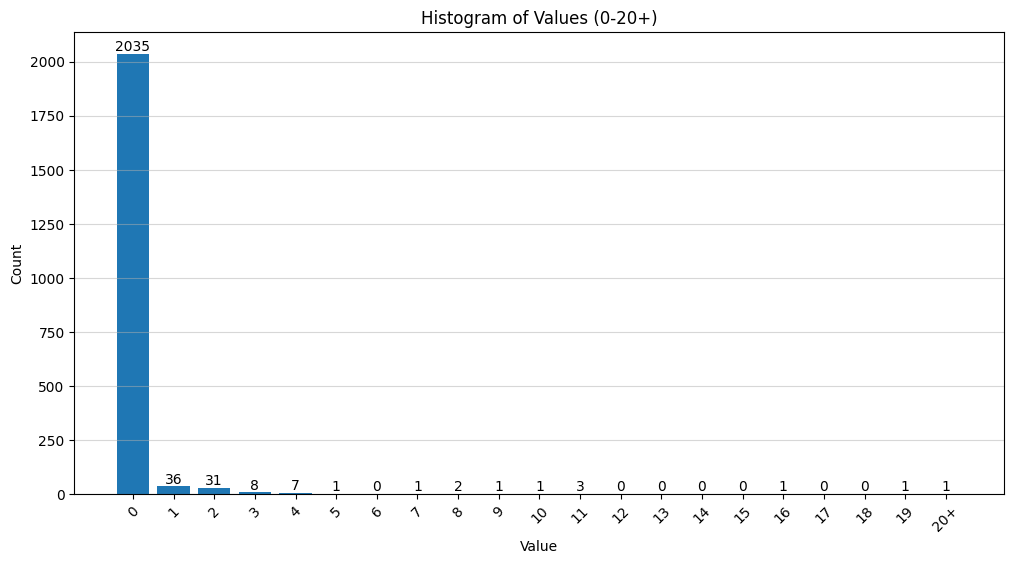

In [11]:
#from task3_2API import detectBoardAndSquares
from api2_0 import detectBoardAndSquares
from chessboardPieces import drawSquares
import shutil
#Load keypoints model
poseModel = YOLO("newyolo11pose.pt") 


resultsDirectory = "./Results"
if os.path.exists(resultsDirectory):
    shutil.rmtree(resultsDirectory)  # Recursively delete directory and all contents
statistics = []
# Create fresh empty folder
os.makedirs(resultsDirectory)
for index,img in enumerate(images):
    print("Index: ",index," Processing image: ", img)
    yoloBB = YoloContours[index]
    yoloBBid = YoloBBids[index]
    gt = GroundTruth[index]
    # Call the function to detect board and squares
    #img = "../images/0/G000_IMG001.jpg"
    normalizedBoard, square_box, M, fx, fy,rotation = detectBoardAndSquares(img,poseModel)
    if(normalizedBoard is not None):
        orientedBoard = rotateBoard(normalizedBoard,rotation)
        """cv2.imshow("Oriented Board",orientedBoard)
        cv2.waitKey()
        cv2.destroyAllWindows()"""
        #orientedBoard,rotation  =findHorse(normalizedBoard,10,5,45,70,debug=False)
        """cv2.imshow("Oriented Board", orientedBoard)
        cv2.waitKey(0)
        cv2.destroyAllWindows()"""
        warped_yoloBB = transform_contours_to_warped_space(yoloBB, M, fy, fx)
        """cv2.drawContours(normalizedBoard, warped_yoloBB, -1, (0, 255, 0), 4)
        normalizedBoard1 = cv2.resize(normalizedBoard, (720, 720), normalizedBoard)
        cv2.imshow("YOLO Boxes", normalizedBoard1)
        cv2.waitKey(0)
        cv2.destroyAllWindows()"""
        square_box2 = copy.deepcopy(square_box)
        #square_box1 = copy.deepcopy(square_box)
        #drawSquares(square_box1,copy.deepcopy(normalizedBoard))
        os.makedirs(os.path.join(resultsDirectory,str(index)))
        matrix = getBoardState(yoloBBid,warped_yoloBB, square_box2, rotation,normalizedBoard)
        predicted = drawBoard(matrix)
        GT_image = drawBoard(gt)
        cv2.imwrite(os.path.join(resultsDirectory,str(index),"Image.jpg"),orientedBoard)
        cv2.imwrite(os.path.join(resultsDirectory,str(index),"Predicted.jpg"),predicted)
        cv2.imwrite(os.path.join(resultsDirectory,str(index),"Ground_Truth.jpg"),GT_image)
        error = count_differences_zip(matrix,gt)
        if(error >0):
            print("Error:",error)
        statistics.append(error)
        """cv2.imshow("Image ", orientedBoard)
        cv2.imshow("Predicted ", predicted)
        cv2.imshow("Ground Truth ", GT_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()"""
    # Print column by column
    """
        for col in range(8):
            for row in range(8):
                print(matrix[row][col], end=' ')
            print() """ 
    # New line after each column
    #drawSquares(square_box,normalizedBoard)
print(statistics)
plot_histogram(statistics,resultsDirectory + "/histogram.png")